In [28]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from collections import Counter

In [29]:
pol_to_rep = {
  -1.0: 10,
  -0.9: 1,
  -0.8: 2,
  -0.7: 3,
  -0.6: 4,
  -0.5: 5,
  -0.4: 6,
  -0.3: 7,
  -0.2: 8,
  -0.1: 9,
  -0.0: 0,
  0.0: 0,
  0.1: 11,
  0.2: 12,
  0.3: 13,
  0.4: 14,
  0.5: 15,
  0.6: 16,
  0.7: 17,
  0.8: 18,
  0.9: 19,
  1.0: 20,
}

rep_to_pol = {
  10 : -1.0,
  1 : -0.9,
  2 : -0.8,
  3 : -0.7,
  4 : -0.6,
  5 : -0.5,
  6 : -0.4,
  7 : -0.3,
  8 : -0.2,
  9 : -0.1,
  0 : 0.0,
  11 : 0.1,
  12 : 0.2,
  13 : 0.3,
  14 : 0.4,
  15 : 0.5,
  16 : 0.6,
  17 : 0.7,
  18 : 0.8,
  19 : 0.9,
  20 : 1.0,
}

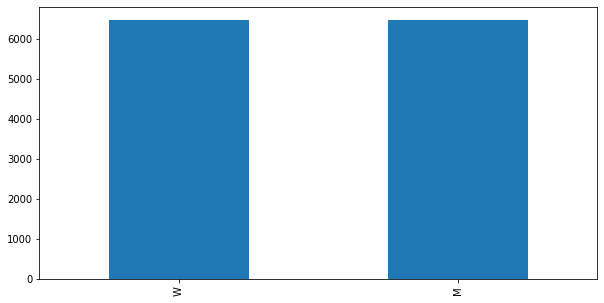

In [30]:
import pandas as pd

df = pd.read_json('../datasets/8_dataset_sliced.json')
df = pd.concat([df.head(15000), df.tail(5000)])

M, W = df["Gender"].value_counts()
if M>W:
    diff = M-W
    df = df.drop(df.loc[df['Gender'] == 'M'].index[:diff], axis=0)
elif W>M:
    diff = W-M
    df = df.drop(df.loc[df['Gender'] == 'W'].index[:diff], axis=0)

df["Gender"].value_counts().plot(kind="bar", figsize=(10,5))
df['Sentiment'] = df.Gender.apply(lambda x: -1 if x == "M" else 1)
df = df.drop('Gender', axis=1)
df['Dep'] = df['Dep'].str.upper()

In [31]:
lemma_vocab = np.unique(df['Lemma']).tolist()
lemma_vocab.insert(0, '<PAD>')

tag_vocab = np.unique(df['Tag']).tolist()
tag_vocab.insert(0, '<PAD>')

pos_vocab = np.unique(df['POS']).tolist()
pos_vocab.insert(0, '<PAD>')

dep_vocab = np.unique(df['Dep']).tolist()
dep_vocab.insert(0, '<PAD>')

df['Polarity_rounded'] = df['Polarity'].apply(lambda s: pol_to_rep[round(float(s), 1)])
polarity_range = []

for i in np.arange(0.0, 2.1, 0.1):
    polarity_range.append(int(round(i*10, 1)))

i_to_lemma = {i:lemma for  i, lemma in enumerate(lemma_vocab)}
lemma_to_i = {lemma:i for  i, lemma in enumerate(lemma_vocab)}

i_to_tag = {i:tag for  i, tag in enumerate(tag_vocab)}
tag_to_i = {tag:i for  i, tag in enumerate(tag_vocab)}

i_to_pos = {i:pos for  i, pos in enumerate(pos_vocab)}
pos_to_i = {pos:i for  i, pos in enumerate(pos_vocab)}

i_to_dep = {i:dep for  i, dep in enumerate(dep_vocab)}
dep_to_i = {dep:i for  i, dep in enumerate(dep_vocab)}

df['Lemma_index'] = df['Lemma'].map(lemma_to_i)
df['Tag_index'] = df['Tag'].map(tag_to_i)
df['POS_index'] = df['POS'].map(pos_to_i)
df['Dep_index'] = df['Dep'].map(dep_to_i)

df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'Tag', 'POS', 'Dep', 'Polarity', 'Sentiment', 'Polarity_rounded', 'Lemma_index', 'Tag_index', 'POS_index', 'Dep_index'].agg(lambda x: list(x))
#df = df.sample(frac=1).reset_index(drop=True)

# df['Word'].apply(lambda s: s.insert(0,"<SOS>"))
# df['Word'].apply(lambda s: s.insert(len(s),"<EOS>"))
# df['Polarity_rounded'].apply(lambda s: s.insert(0,10))
# df['Polarity_rounded'].apply(lambda s: s.insert(len(s),10))


print(polarity_range)

df.head(2)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


C:\Users\hanse\AppData\Local\Temp/ipykernel_2648/3287278792.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'Tag', 'POS', 'Dep', 'Polarity', 'Sentiment', 'Polarity_rounded', 'Lemma_index', 'Tag_index', 'POS_index', 'Dep_index'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,Tag,POS,Dep,Polarity,Sentiment,Polarity_rounded,Lemma_index,Tag_index,POS_index,Dep_index
0,1,"[organizations, decided, drop, women, accused,...","[organization, decide, drop, woman, accuse, in...","[NNS, VBN, VB, NNS, VBD, JJ, NN, JJ, NN]","[NOUN, VERB, VERB, NOUN, VERB, ADJ, NOUN, ADJ,...","[NSUBJ, ROOT, XCOMP, NSUBJ, ADVCL, AMOD, POBJ,...","[0.506489491162892, 0.32769425602846003, -0.12...","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[15, 13, 9, 0, 11, 0, 0, 7, 17]","[2558, 1330, 1489, 3735, 649, 2059, 885, 3128,...","[18, 28, 25, 18, 26, 9, 15, 9, 15]","[8, 16, 16, 8, 16, 1, 8, 1, 8]","[23, 36, 37, 23, 3, 5, 29, 5, 13]"
1,2,"[Women, previously, worked, winning, actor, to...","[woman, previously, work, win, actor, tell, CN...","[NNS, RB, VBD, VBG, NN, VBD, NNP, RB, NNS, NNS...","[NOUN, ADV, VERB, VERB, NOUN, VERB, PROPN, ADV...","[NSUBJ, ADVMOD, RELCL, AMOD, POBJ, ROOT, DOBJ,...","[0.0, -0.111174966250348, 0.0, 0.7726255539569...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 9, 0, 18, 11, 0, 0, 0, 2, 7, 20, 0, 9, 0, 0]","[3735, 2756, 3740, 3722, 661, 3428, 117, 2955,...","[18, 19, 26, 27, 15, 26, 16, 19, 18, 18, 15, 1...","[8, 3, 16, 16, 8, 16, 12, 3, 8, 8, 8, 3, 16, 1...","[23, 4, 35, 5, 29, 36, 18, 4, 18, 29, 13, 4, 1..."


No handles with labels found to put in legend.


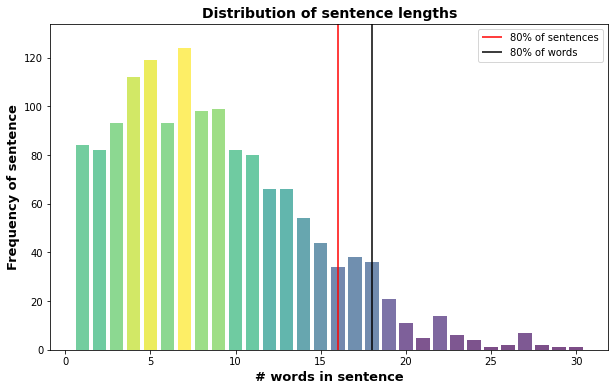

In [32]:
sentence_plot = df["Lemma"].values
sentence_plot_sorted = list(sorted(sentence_plot, key=len))
c = Counter(map(len, sentence_plot_sorted))

total_sentences = 0
total_words = 0
for i in c:
    total_sentences = total_sentences + c[i]
    total_words = total_words + c[i]*i

sentences_80_pct = total_sentences / 100 * 90
words_80_pct = total_words / 100 * 90

boundary_sen = 0
counter_sen = 0

for i in c:
    if(counter_sen + c[i] < int(sentences_80_pct)):
        counter_sen = counter_sen + c[i]
        boundary_sen = i
    else:
        break

boundary_word = 0
counter_word = 0

for i in c:
    if(counter_word + c[i] * i < int(words_80_pct)):
        counter_word = counter_word + c[i] * i
        boundary_word = i
    else:
        break


my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))


plt.figure(figsize=[10,6])
bars = plt.bar(list(c.keys()), list(c.values()), color=my_cmap(rescale(list(c.values()))), width=0.8, alpha=0.7, align='center')

# for r in bars.get_children():
#     if(r.get_x() > boundary_sen):
#         r.set_alpha(0.2)

plt.legend(loc="best")
plt.ylim([0, max(list(c.values()))+10])
ax2 = plt.gca()

ymin, ymax = ax2.get_ylim()
plt.vlines(boundary_sen, ymin=ymin, ymax=ymax, colors='r', label='80% of sentences')
plt.vlines(boundary_word, ymin=ymin, ymax=ymax, colors='black', label="80% of words")

plt.ylabel('Frequency of sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
plt.xlabel('# words in sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
plt.title("Distribution of sentence lengths", fontdict={'fontsize':14, 'fontweight': 'bold'})
plt.legend()
plt.show()

In [41]:
tokens = df['Lemma_index'].tolist()
pos = df['POS_index'].tolist()
polarities = df['Polarity_rounded'].tolist()

max_length = boundary_sen
pad_type = 'post'

pad_tokens = pad_sequences(tokens, maxlen=max_length, dtype='int32', padding=pad_type)
pad_pos = pad_sequences(pos, maxlen=max_length, dtype='int32', padding=pad_type)

pad_polarities = pad_sequences(polarities, maxlen=max_length, dtype='int32', padding=pad_type, value=0)
pad_polarities = [to_categorical(i, num_classes=len(pol_to_rep)) for i in pad_polarities]

train_tokens, test_tokens, train_polarities, test_polarities = train_test_split(pad_tokens, pad_polarities, test_size=0.25)
train_pos, test_pos, train_polarities, test_polarities = train_test_split(pad_pos, pad_polarities, test_size=0.25)

In [42]:
import os
import time
import tensorflow as tf
from keras import callbacks

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

model_name = 'words_multi_label_multi_feature'
model_variant = 'base_sliced'

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        exp = lr0 * 0.1**(epoch / s)
        tf.summary.scalar('learning rate', data=exp, step=epoch)
        return exp
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=10)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

mcp_save = callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

my_callbacks = [earlystopping, lr_scheduler, tensorboard_cb]

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_input (InputLayer)        [(None, 16)]         0                                            
__________________________________________________________________________________________________
pos_input (InputLayer)          [(None, 16)]         0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, 16, 64)       241536      token_input[0][0]                
                                                                 pos_input[0][0]                  
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 16, 128)      0           shared_embedding[0][0]     

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


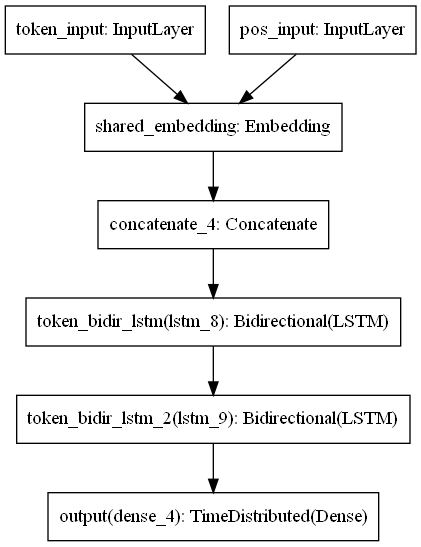

In [43]:
# Borrowed from: https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks
import numpy as np
import tensorflow as tf

input_dim = len(lemma_vocab)+1
embedding_dim = 128
output_dim = 64

token_input = keras.Input(shape=(max_length,), name='token_input')
pos_input = keras.Input(shape=(max_length,), name='pos_input')

shared_embedding = layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length, mask_zero=True, name='shared_embedding')
bidir_lstm = layers.Bidirectional(layers.LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat', name='token_bidir_lstm')
bidir_lstm_2 = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), merge_mode = 'concat', name='token_bidir_lstm_2')

token_embedding = shared_embedding(token_input)
pos_embedding = shared_embedding(pos_input)

concat = layers.concatenate([token_embedding, pos_embedding])
bidir1 = bidir_lstm(concat)
bidir2 = bidir_lstm_2(bidir1)
output = layers.TimeDistributed(layers.Dense(len(pol_to_rep), activation="softmax"), name='output')(bidir2)

model = keras.Model(inputs=[token_input, pos_input], outputs=[output])

adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 
model.summary()
plot_model(model)

In [44]:
history = model.fit([train_tokens, train_pos], np.array(train_polarities), epochs=50, callbacks=my_callbacks, validation_split=0.2)

model.save('classifiers/' + model_name + '/' + model_variant + '.h5')

Epoch 1/50
28/28 [==============================] - 19s 226ms/step - loss: 0.7535 - accuracy: 0.5563 - val_loss: 0.6457 - val_accuracy: 0.5683
Epoch 2/50
28/28 [==============================] - 2s 72ms/step - loss: 0.6519 - accuracy: 0.5779 - val_loss: 0.6522 - val_accuracy: 0.5675
Epoch 3/50
28/28 [==============================] - 2s 72ms/step - loss: 0.6006 - accuracy: 0.5779 - val_loss: 0.6826 - val_accuracy: 0.5675
Epoch 4/50
28/28 [==============================] - 2s 70ms/step - loss: 0.5506 - accuracy: 0.5777 - val_loss: 0.7591 - val_accuracy: 0.5683
Epoch 5/50
28/28 [==============================] - 2s 67ms/step - loss: 0.5045 - accuracy: 0.5799 - val_loss: 0.8754 - val_accuracy: 0.5541
Epoch 6/50
28/28 [==============================] - 2s 66ms/step - loss: 0.4751 - accuracy: 0.5842 - val_loss: 0.9142 - val_accuracy: 0.5147
Epoch 7/50
28/28 [==============================] - 2s 65ms/step - loss: 0.4525 - accuracy: 0.5963 - val_loss: 0.9800 - val_accuracy: 0.4677
Epoch 8/50


In [57]:
y_pred = model.predict([test_tokens, test_pos])

In [66]:
y_pred[350].argmax()

84

[ 0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  9  0  0  0  0  0  0
  0  0  0  0  0  0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.77989865 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


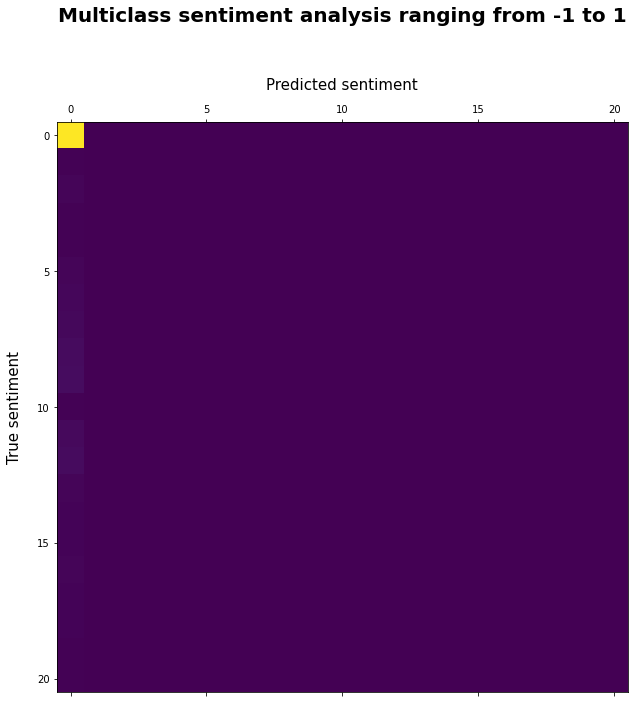

In [49]:
from sklearn.metrics import confusion_matrix
from itertools import chain

y_classes = y_pred.argmax(axis=-1)
cm_true = np.array(test_polarities).argmax(axis=-1).flatten()
cm_pred = y_classes.flatten()

#cm_true = [x - 10 for x in cm_true]
#cm_pred = [x - 10 for x in cm_pred]


print(cm_true[:30], cm_pred[:30])


cm = confusion_matrix(cm_true, cm_pred, normalize='pred')

print(cm[0])

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted sentiment', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True sentiment', fontsize = 15, labelpad=15.0)
ax.set_title('Multiclass sentiment analysis ranging from -1 to 1',fontweight="bold", size=20, pad=100.0)

conf_x = []

temp = set(chain(*df['Polarity_rounded']))

for i in temp:
    conf_x.append(i)

print(sorted(conf_x))

cm_axis_vals = []

for x in np.unique(np.array(cm_pred)):
    cm_axis_vals.append(rep_to_pol[x])



In [47]:
np.unique(np.array(cm_pred))

array([0], dtype=int64)

ValueError: The number of FixedLocator locations (21), usually from a call to set_ticks, does not match the number of ticklabels (1).

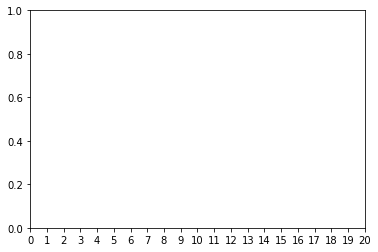

In [48]:

fig.colorbar(cax)
plt.xticks(range(len(cm[0])),cm_axis_vals, rotation=90)
plt.yticks(range(len(cm[0])), cm_axis_vals)
plt.show()

In [ ]:
report = classification_report(cm_true, cm_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:11]
df_perf_2.insert(loc=0, column='Polarity', value=conf_x)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

In [ ]:
y_pred.argmax(axis=-1)
min_sent = 7
max_sent = 14
for i, pred_sentiment in enumerate(y_pred.argmax(axis=-1)):
    avg_sent = sum(pred_sentiment) 
    if avg_sent < min_sent or avg_sent > max_sent:
        print('--------------------------------------------------------------------------')
        print('Sentence at index:', i, 'has a gender bias.\nThe average sentiment of the sentence is:', round((avg_sent/10)-1, 2))
        print('The sentence is: "' + " ".join(df.iloc[[i]]['Word'].tolist()[0]) + '"')
        polarities = df.iloc[[i]]['Polarity'].tolist()[0]
        index_biased_word = np.argmin(polarities) if avg_sent < min_sent else np.argmax(polarities)
        print('The bias most likely stems from the use of:', df.iloc[[i]]['Word'].tolist()[0][index_biased_word] + ', polarity is', round(df.iloc[[i]]['Polarity'].tolist()[0][index_biased_word], 2))
        print(pred_sentiment[index_biased_word])

NameError: name 'y_pred' is not defined